## Clone IndoNLU

In [3]:
!git clone https://github.com/indobenchmark/indonlu

Cloning into 'indonlu'...


## IMPORT UTILS

In [2]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

## LOAD PRETRAINED MODEL

In [4]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def count_param(module, trainable=False):
  if trainable:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def metrics_to_string(metric_dict):
  string_list = []
  for key, value in metric_dict.items():
    string_list.append('{}:{:.2f}'.format(key, value))
  return ' '.join(string_list)

In [5]:
# Set Random Seed
set_seed(15062024) # untuk memudahkan dalam membuat tanggal saat membuat projek

In [6]:
# Load Tokenizer and Config

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate Model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
count_param(model)

124443651

## Load Dataset IndoNLU

In [15]:
train_dataset_path = '/KULIAH/SKRIPSI/BAB SKRIPSI/PENELITIAN//indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv'
valid_dataset_path = '/KULIAH/SKRIPSI/BAB SKRIPSI/PENELITIAN//indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv'
test_dataset_path = '/KULIAH/SKRIPSI/BAB SKRIPSI/PENELITIAN//indonlu/dataset/smsa_doc-sentiment-prosa/test_preprocess_masked_label.tsv'

In [16]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [20]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

with torch.no_grad():
    logits = model(subwords)[0]
    label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
    probabilities = F.softmax(logits, dim=-1).squeeze()

print(f'Text: {text} | Label : {i2w[label]} ({probabilities[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : negative (51.104%)


## Training Dataset IndoNLU

In [21]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [22]:
# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

  0%|          | 0/344 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
(Epoch 1) TRAIN LOSS:0.3407 LR:0.00000300: 100%|██████████| 344/344 [07:16<00:00,  1.27s/it]  


(Epoch 1) TRAIN LOSS:0.3407 ACC:0.87 F1:0.83 REC:0.80 PRE:0.86 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1979 ACC:0.93 F1:0.90 REC:0.89 PRE:0.91: 100%|██████████| 40/40 [01:48<00:00,  2.72s/it] 


(Epoch 1) VALID LOSS:0.1979 ACC:0.93 F1:0.90 REC:0.89 PRE:0.91


  0%|          | 0/344 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.1570 LR:0.00000300: 100%|██████████| 344/344 [07:22<00:00,  1.29s/it]


(Epoch 2) TRAIN LOSS:0.1570 ACC:0.95 F1:0.93 REC:0.93 PRE:0.94 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1774 ACC:0.93 F1:0.91 REC:0.90 PRE:0.92: 100%|██████████| 40/40 [01:28<00:00,  2.21s/it]


(Epoch 2) VALID LOSS:0.1774 ACC:0.93 F1:0.91 REC:0.90 PRE:0.92


  0%|          | 0/344 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.1160 LR:0.00000300: 100%|██████████| 344/344 [08:08<00:00,  1.42s/it]


(Epoch 3) TRAIN LOSS:0.1160 ACC:0.96 F1:0.95 REC:0.95 PRE:0.96 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1903 ACC:0.93 F1:0.91 REC:0.91 PRE:0.92: 100%|██████████| 40/40 [01:18<00:00,  1.96s/it]


(Epoch 3) VALID LOSS:0.1903 ACC:0.93 F1:0.91 REC:0.91 PRE:0.92


  0%|          | 0/344 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.0876 LR:0.00000300: 100%|██████████| 344/344 [08:28<00:00,  1.48s/it]


(Epoch 4) TRAIN LOSS:0.0876 ACC:0.97 F1:0.96 REC:0.96 PRE:0.97 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1865 ACC:0.94 F1:0.91 REC:0.90 PRE:0.94: 100%|██████████| 40/40 [01:31<00:00,  2.29s/it]


(Epoch 4) VALID LOSS:0.1865 ACC:0.94 F1:0.91 REC:0.90 PRE:0.94


  0%|          | 0/344 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.0653 LR:0.00000300: 100%|██████████| 344/344 [08:14<00:00,  1.44s/it]


(Epoch 5) TRAIN LOSS:0.0653 ACC:0.98 F1:0.97 REC:0.97 PRE:0.98 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1905 ACC:0.94 F1:0.91 REC:0.91 PRE:0.92: 100%|██████████| 40/40 [02:06<00:00,  3.17s/it]  


(Epoch 5) VALID LOSS:0.1905 ACC:0.94 F1:0.91 REC:0.91 PRE:0.92


In [23]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

  0%|          | 0/16 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 16/16 [01:19<00:00,  4.94s/it]


     index     label
0        0  negative
1        1  negative
2        2  negative
3        3  negative
4        4  negative
..     ...       ...
495    495   neutral
496    496   neutral
497    497   neutral
498    498  positive
499    499  positive

[500 rows x 2 columns]


  0%|          | 0/16 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 16/16 [01:16<00:00,  4.76s/it]


In [24]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (99.678%)


## LOAD DATASET RAW

In [27]:
data = pd.read_csv('d:/KULIAH/SKRIPSI/BAB SKRIPSI/PENELITIAN/DatasetBiznetBARU1.csv')
data.head(5)

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1803813270995824797,Fri Jun 21 07:34:46 +0000 2024,0,@kumancantik aku pake biznet kak cipa cepett,1804055345943449710,NaN,kumancantik,in,NaN,0,0,0,https://x.com/everlastaeing/status/18040553459...,1306129962773012480,everlastaeing
1,1804032040402325617,Fri Jun 21 06:02:10 +0000 2024,2,Efek pandemi Covid-19 membuat perubahan perila...,1804032040402325617,NaN,NaN,in,Jakarta,0,0,1,https://x.com/kompascom/status/180403204040232...,23343960,kompascom
2,1804022151957352799,Fri Jun 21 05:55:30 +0000 2024,0,@YehezGun tul contabo murah itu atau mau naik ...,1804030361732595908,https://pbs.twimg.com/media/GQky7XHakAMj5Yc.png,YehezGun,in,Bekasi,0,1,0,https://x.com/ramandann/status/180403036173259...,237172744,ramandann
3,1804026539857649926,Fri Jun 21 05:40:18 +0000 2024,1,Sempurnakan Hidupmu #PakeBiznet Biznet Home In...,1804026539857649926,https://pbs.twimg.com/media/GQkwkxCa4AANeaA.jpg,NaN,in,Yogyakarta,0,1,0,https://x.com/bznetjogja/status/18040265398576...,359311572,bznetjogja
4,1804014017028952570,Fri Jun 21 04:50:33 +0000 2024,0,biznet adalah wifi terproblematik yang pernah ...,1804014017028952570,NaN,NaN,in,NaN,0,0,0,https://x.com/sakumeengg/status/18040140170289...,1803113350345400320,sakumeengg


## Select Data

In [28]:
selected_data = data[['full_text']]
selected_data.head(5)

,full_text
0,@kumancantik aku pake biznet kak cipa cepett
1,Efek pandemi Covid-19 membuat perubahan perila...
2,@YehezGun tul contabo murah itu atau mau naik ...
3,Sempurnakan Hidupmu #PakeBiznet Biznet Home In...
4,biznet adalah wifi terproblematik yang pernah ...


## Mengganti Kata

In [29]:
stopwords = ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'setelah', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'apakah', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 'sebetulnya', 'setiap', 'setidaknya', 'sesuatu', 'pasti', 'saja', 'toh', 'ya', 'walau', 'tolong', 'tentu', 'amat', 'apalagi', 'bagaimanapun', 'sekali', 'jadi', 'nya']
keep_stopwords = ['tidak', 'sementara', 'belum', 'tetapi', 'kecuali', 'tapi', 'ada', 'tanpa', 'nggak', 'ok', 'hanya', 'kurang']
fix_stopwords = [next if word in keep_stopwords else word for word in stopwords]

In [30]:
words_dict = {
    'tdk'  : 'tidak',
    'yg' : 'yang',
    'ga' : 'tidak',
    'gak' : 'tidak',
    'tp' : 'tapi',
    'd' : 'di',
    'sy' : 'saya',
    '&' : 'dan',
    'dgn' : 'dengan',
    'utk' : 'untuk',
    'gk' : 'tidak',
    'jd' : 'jadi',
    'jg' : 'juga',
    'dr' : 'dari',
    'krn' : 'karena',
    'aja' : 'saja',
    'karna' : 'karena',
    'udah' : 'sudah',
    'kmr' : 'kamar',
    'g' : 'tidak',
    'dpt' : 'dapat',
    'banget' : 'sekali',
    'bgt' : 'sekali',
    'kalo' : 'kalau',
    'n' : 'dan',
    'bs' : 'bisa',
    'oke' : 'ok',
    'dg' : 'dengan',
    'pake' : 'pakai',
    'sampe' : 'sampai',
    'dapet' : 'dapat',
    'ad' : 'ada',
    'lg' : 'lagi',
    'bikin' : 'buat',
    'tak' : 'tidak',
    'ny' : 'nya',
    'ngga' : 'tidak',
    'nunggu' : 'tunggu',
    'klo' : 'kalau',
    'blm' : 'belum',
    'trus' : 'terus',
    'kayak' : 'seperti',
    'dlm' : 'dalam',
    'udh' : 'sudah',
    'tau' : 'tahu',
    'org' : 'orang',
    'hrs' : 'harus',
    'msh' : 'masih',
    'sm' : 'sama',
    'byk' : 'banyak',
    'krg' : 'kurang',
    'kmar' : 'kamar',
    'spt' : 'seperti',
    'pdhl' : 'padahal',
    'chek' : 'cek',
    'pesen' : 'pesan',
    'kran' : 'keran',
    'gitu' : 'begitu',
    'tpi' : 'tapi',
    'lbh' : 'lebih',
    'tmpt' : 'tempat',
    'dikasi' : 'dikasih',
    'serem' : 'seram',
    'sya' : 'saya',
    'jgn' : 'jangan',
    'dri' : 'dari',
    'dtg' : 'datang',
    'gada' : 'tidak ada',
    'standart' : 'standar',
    'mlm' : 'malam',
    'k'  : 'ke',
    'kl' : 'kalau',
    'sgt': 'sangat',
    'y' : 'ya',
    'krna' : 'karena',
    'tgl' : 'tanggal',
    'terimakasih' : 'terima kasih',
    'kecoak' : 'kecoa',
    'pd' : 'pada',
    'tdr' : 'tidur',
    'jdi' : 'jadi',
    'kyk' : 'seperti',
    'sdh' : 'sudah',
    'ama' : 'sama',
    'gmana' : 'bagaimana',
    'dalem' : 'dalam',
    'tanyak' : 'tanya',
    'taru' : 'taruh',
    'gede' : 'besar',
    'kaya' : 'seperti',
    'access' : 'akses',
    'tetep' : 'tetap',
    'mgkin' : 'mungkin',
    'sower' : 'shower',
    'idup' : 'hidup',
    'nyaaa' : 'nya',
    'baikk' : 'baik',
    'hanay' : 'hanya',
    'tlp' : 'telpon',
    'kluarga' : 'keluarga',
    'jln' : 'jalan',
    'hr' : 'hari',
    'ngak' : 'tidak',
    'bli' : 'beli',
    'kmar' : 'kamar',
    'naro' : 'taruh',
    'gaada' : 'tidak ada'
}

## CLEANING TEXT

In [31]:
import re
import string

selected_data['full_text_cleaned'] = [i.lower() for i in selected_data['full_text']]

# removing \x00 characters
selected_data['full_text_cleaned'] = [re.sub(r'[^\x00-\x7f]',r'', i) for i in selected_data['full_text_cleaned']]

#r removing \n
selected_data['full_text_cleaned'] = [re.sub(r'\n', r' ', i) for i in selected_data['full_text_cleaned']]

#r removing numbers
selected_data['full_text_cleaned'] = [re.sub(r"\d+", r"", i) for i in selected_data['full_text_cleaned']]

#removing punctuation
selected_data['full_text_cleaned'] = [i.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for i in selected_data['full_text_cleaned']]

def num_count(data, feature) :
    num_list = []
    for sentence in tqdm(data[feature]) :
        num = 0
        for word in sentence :
            if word.isdigit() :
                num += 1
            else :
                num += 0
        num_list.append(num)
    return num_list

selected_data['num_of_space'] = [i.count(' ') for i in selected_data['full_text_cleaned']]

selected_data['num_of_words'] = [len(i.split()) for i in selected_data['full_text_cleaned']]

selected_data['num_unique_char'] = [len(set(i)) for i in selected_data['full_text_cleaned']]

selected_data['len_string_initial'] = [len(i) for i in selected_data['full_text']]

selected_data['num_of_numeric'] = num_count(selected_data, 'full_text')

C:\Users\andri\AppData\Local\Temp\ipykernel_16336\2987783834.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned'] = [i.lower() for i in selected_data['full_text']]
C:\Users\andri\AppData\Local\Temp\ipykernel_16336\2987783834.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned'] = [re.sub(r'[^\x00-\x7f]',r'', i) for i in selected_data['full_text_cleaned']]
C:\Users\andri\AppData\Local\Temp\ipykernel_16336\2987783834.py:10: SettingWithCopyWarn

In [32]:
def remove_indonesian_stop(data, feature) :
    stopwords = fix_stopwords
    filtered = []
    for text in data[feature] :
        text_list = []
        for word in text.split() :
            if word not in stopwords :
                text_list.append(word)
        text_list = ' '.join(text_list)
        filtered.append(text_list)
    return filtered

In [33]:
list_sentence_selected_data = []
for sentence in tqdm(selected_data['full_text_cleaned']) :
    cleaned_sentence = [words_dict[word] if word in list(words_dict.keys()) else word for word in sentence.split()]
    list_sentence_selected_data.append(' '.join(cleaned_sentence))
selected_data['full_text_cleaned'] = list_sentence_selected_data

#removing indonesian stopwords
selected_data['full_text_cleaned_nostopwords'] = remove_indonesian_stop(selected_data, 'full_text_cleaned')

100%|██████████| 1601/1601 [00:00<00:00, 27242.26it/s]
C:\Users\andri\AppData\Local\Temp\ipykernel_16336\1084395976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned'] = list_sentence_selected_data
C:\Users\andri\AppData\Local\Temp\ipykernel_16336\1084395976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['full_text_cleaned_nostopwords'] = remove_indonesian_stop(selected_data, 'full_text_cleaned')


## LABELLING DATA

In [34]:
# Fungsi untuk mengonversi label angka menjadi label teks
def convert_label_to_text(label):
    return i2w[label]

# Fungsi untuk melakukan pelabelan pada teks
def label_text(text):
    # Tokenisasi teks
    subwords = tokenizer.encode(text)
    subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

    # Prediksi label
    logits = model(subwords)[0]
    label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

    return convert_label_to_text(label)

# Membuat kolom baru untuk menyimpan hasil pelabelan
selected_data['sentiment'] = ''

# Melabelkan setiap teks pada kolom full_text dan menambahkan hasil pelabelan ke kolom baru
for index, row in selected_data.iterrows():
    text = row['full_text_cleaned_nostopwords']
    label = label_text(text)
    selected_data.at[index, 'sentiment'] = label

C:\Users\andri\AppData\Local\Temp\ipykernel_16336\3906393107.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['sentiment'] = ''


In [35]:
selected_data.head(5)

,full_text,full_text_cleaned,num_of_space,num_of_words,num_unique_char,len_string_initial,num_of_numeric,full_text_cleaned_nostopwords,sentiment
0,@kumancantik aku pake biznet kak cipa cepett,kumancantik aku pakai biznet kak cipa cepett,7,7,13,44,0,kumancantik aku pakai biznet kak cipa cepett,positive
1,Efek pandemi Covid-19 membuat perubahan perila...,efek pandemi covid membuat perubahan perilaku ...,21,18,23,144,3,efek pandemi covid membuat perubahan perilaku ...,neutral
2,@YehezGun tul contabo murah itu atau mau naik ...,yehezgun tul contabo murah itu atau mau naik d...,53,50,27,295,3,yehezgun tul contabo murah mau naik dikit bizn...,negative
3,Sempurnakan Hidupmu #PakeBiznet Biznet Home In...,sempurnakan hidupmu pakebiznet biznet home int...,25,17,23,171,12,sempurnakan hidupmu pakebiznet biznet home int...,neutral
4,biznet adalah wifi terproblematik yang pernah ...,biznet adalah wifi terproblematik yang pernah ...,9,10,22,71,0,biznet wifi terproblematik pernah ku temukan s...,neutral


In [36]:
modeling_data = selected_data[['full_text_cleaned_nostopwords', 'sentiment']]

In [37]:
modeling_data.rename(columns={'full_text_cleaned_nostopwords': 'text'}, inplace=True)

C:\Users\andri\AppData\Local\Temp\ipykernel_16336\968888182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeling_data.rename(columns={'full_text_cleaned_nostopwords': 'text'}, inplace=True)


In [38]:
modeling_data

,text,sentiment
0,kumancantik aku pakai biznet kak cipa cepett,positive
1,efek pandemi covid membuat perubahan perilaku ...,neutral
2,yehezgun tul contabo murah mau naik dikit bizn...,negative
3,sempurnakan hidupmu pakebiznet biznet home int...,neutral
4,biznet wifi terproblematik pernah ku temukan s...,neutral
...,...,...
1596,roheartss biznet sekarang ada fup bandwitch ke...,neutral
1597,sih biznet bermasalah mulu pas butuh,negative
1598,biznet lemot fak,negative
1599,biznethome hello biznet area rumah masa x mati...,neutral


In [39]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

In [40]:
# Melihat nilai unik dan jumlahnya pada kolom 'sentiment'
sentiment_counts = selected_data['sentiment'].value_counts()
sentiment_counts

sentiment
neutral     748
negative    695
positive    158
Name: count, dtype: int64

## EDA Exploratory Data Analysis

C:\Users\andri\AppData\Local\Temp\ipykernel_16336\3149582501.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=selected_data, x='sentiment', palette=colors)


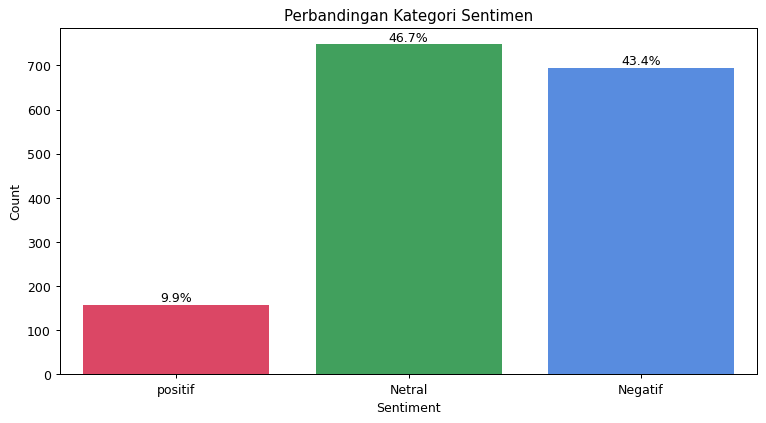

In [41]:
# selected_data.groupby('sentiment').size().plot(kind='bar')

import seaborn as sns
import matplotlib.pyplot as plt

# Define colors
colors = ['#F42E56', '#31B057', '#4287f5']  # Red, Green, Blue

# Plot using Seaborn
plt.figure(figsize=(10, 5), dpi=90)
ax = sns.countplot(data=selected_data, x='sentiment', palette=colors)

# Set labels for each category
plt.xticks([0, 1, 2], ['positif', 'Netral', 'Negatif'])

# Add percentage text
total = len(selected_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Set title and labels
plt.title('Perbandingan Kategori Sentimen')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show plot
plt.show()

In [42]:
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

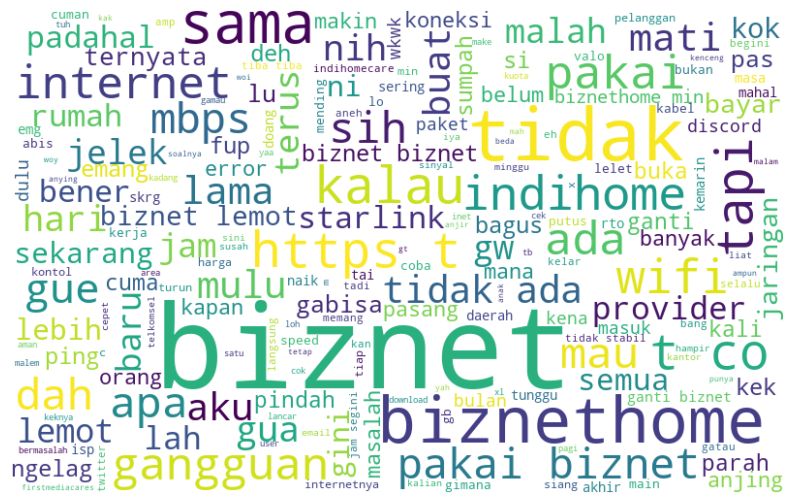

In [43]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in modeling_data['text'][modeling_data['sentiment'] == 'negative'])
wordCloud(negative_words)

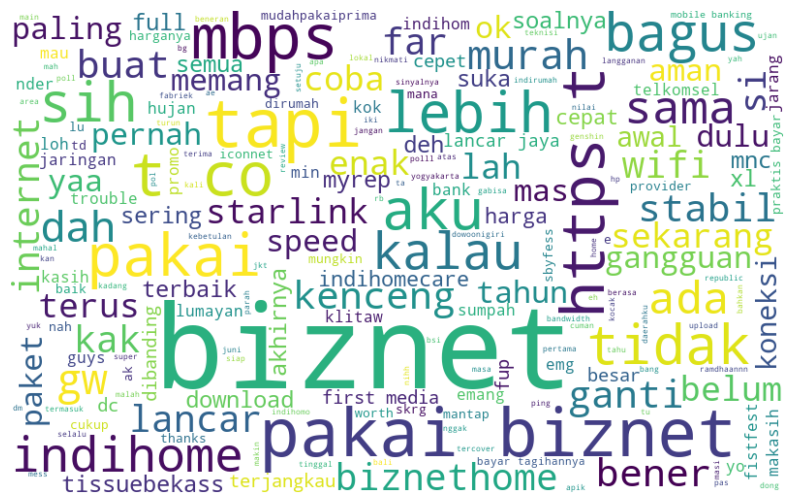

In [44]:
# Melihat kata-kata yang positif
positive_words = ' '.join(text for text in modeling_data['text'][modeling_data['sentiment'] == 'positive'])
wordCloud(positive_words)

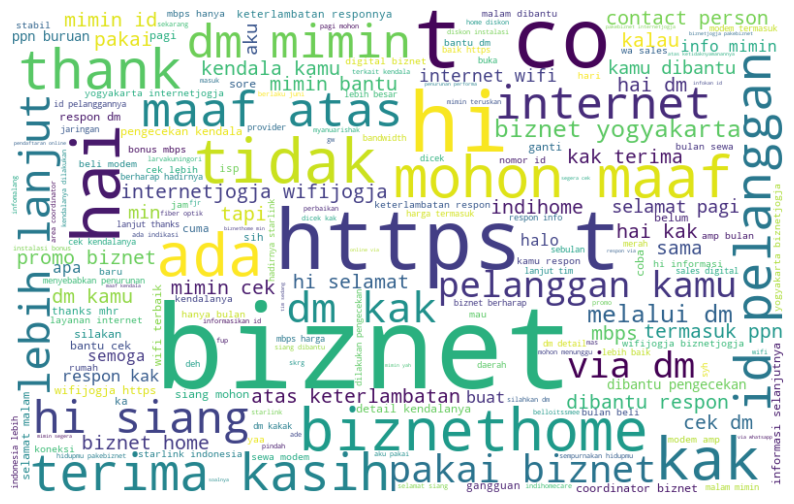

In [45]:
# Melihat kata-kata yang netral
neutral_words = ' '.join(text for text in modeling_data['text'][modeling_data['sentiment'] == 'neutral'])
wordCloud(neutral_words)

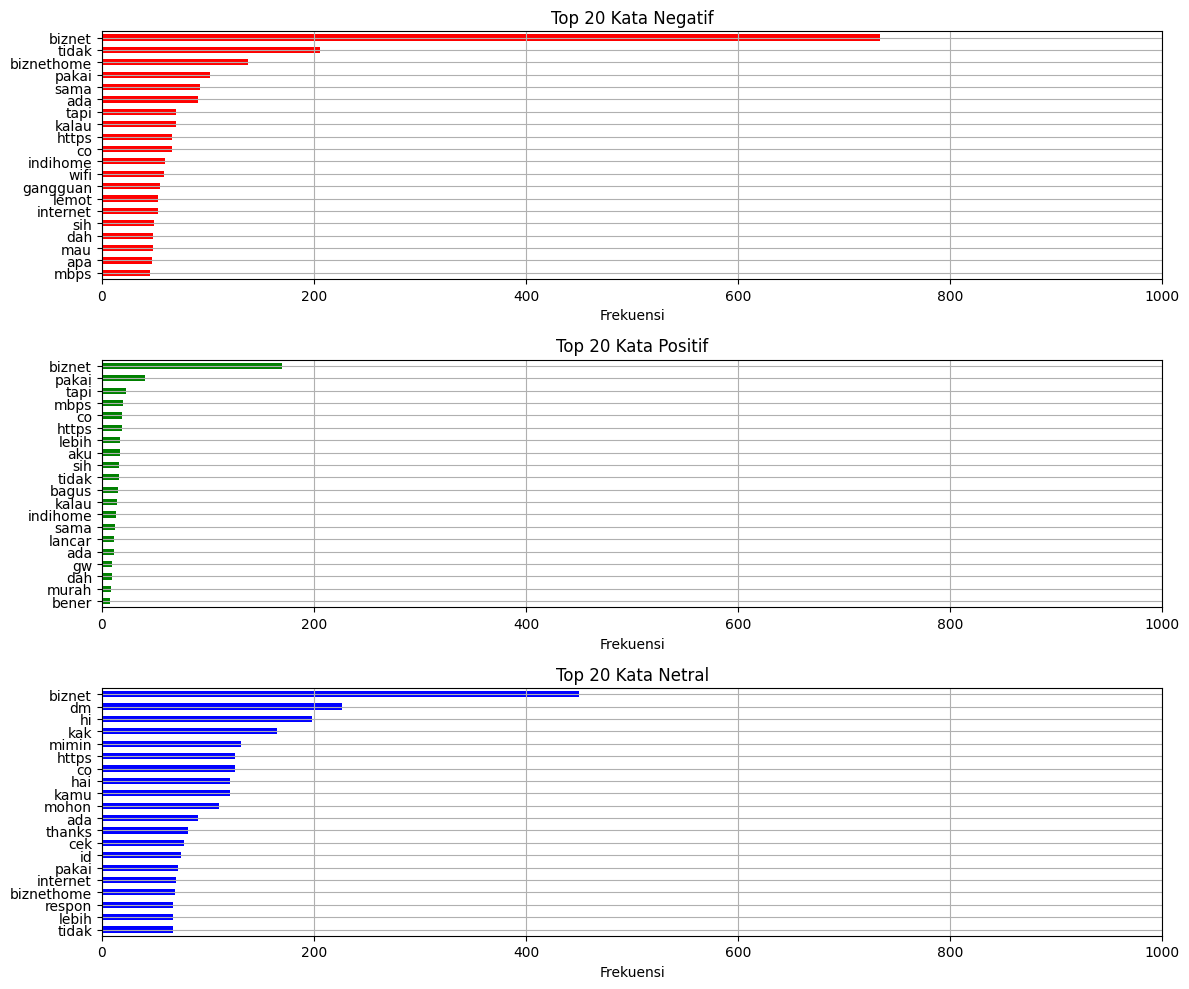

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Membuat CountVectorizer dengan max_features=1000
cv = CountVectorizer(max_features=1000)

# Mengubah teks menjadi vektor fitur
X = cv.fit_transform(modeling_data['text'])

# Membuat DataFrame untuk memudahkan pengolahan data
word_freq_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

# Menambahkan kolom sentimen ke DataFrame
word_freq_df['sentiment'] = modeling_data['sentiment'].values

# Memilih hanya kata-kata yang sesuai dengan kategori sentimen
negative_words_df = word_freq_df[word_freq_df['sentiment'] == 'negative'].drop(columns=['sentiment'])
positive_words_df = word_freq_df[word_freq_df['sentiment'] == 'positive'].drop(columns=['sentiment'])
neutral_words_df = word_freq_df[word_freq_df['sentiment'] == 'neutral'].drop(columns=['sentiment'])

# Menghitung total frekuensi kemunculan kata-kata untuk setiap kategori
negative_word_freq = negative_words_df.sum(axis=0)
positive_word_freq = positive_words_df.sum(axis=0)
neutral_word_freq = neutral_words_df.sum(axis=0)

# Mengurutkan berdasarkan frekuensi kemunculan kata-kata
top_negative_words = negative_word_freq.sort_values(ascending=False)[:20]
top_positive_words = positive_word_freq.sort_values(ascending=False)[:20]
top_neutral_words = neutral_word_freq.sort_values(ascending=False)[:20]

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
top_negative_words.sort_values().plot(kind='barh', color='red')
plt.title('Top 20 Kata Negatif')
plt.xlabel('Frekuensi')
plt.gca().set_xlim([0, 1000])
plt.grid(True)

plt.subplot(3, 1, 2)
top_positive_words.sort_values().plot(kind='barh', color='green')
plt.title('Top 20 Kata Positif')
plt.xlabel('Frekuensi')
plt.gca().set_xlim([0, 1000])
plt.grid(True)

plt.subplot(3, 1, 3)
top_neutral_words.sort_values().plot(kind='barh', color='blue')
plt.title('Top 20 Kata Netral')
plt.xlabel('Frekuensi')
plt.gca().set_xlim([0, 1000])
plt.grid(True)

plt.tight_layout()
plt.show()

## SPLITTING DATA SEQUENTIAL

In [47]:
from sklearn.model_selection import train_test_split

# Bagi data menjadi train dan sisanya (validasi + pengujian)
train_data, remaining_data = train_test_split(modeling_data, test_size=0.2, random_state=42)

# Bagi sisa data menjadi set validasi dan pengujian
valid_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

# Periksa ukuran setiap set
print("Jumlah data pelatihan:", len(train_data))
print("Jumlah data validasi:", len(valid_data))
print("Jumlah data pengujian:", len(test_data))

Jumlah data pelatihan: 1280
Jumlah data validasi: 160
Jumlah data pengujian: 161


## TRAINING DATASET WITH MODEL INDONLU

In [48]:
# Save train_data to TSV
train_data.to_csv('train_data.tsv', sep='\t', index=False, header=False)

# Save valid_data to TSV
valid_data.to_csv('valid_data.tsv', sep='\t', index=False, header=False)

# Save test_data to TSV
test_data.to_csv('test_data.tsv', sep='\t', index=False, header=False)

In [49]:
train_dataset_path = 'train_data.tsv'
valid_dataset_path = 'valid_data.tsv'
test_dataset_path = 'test_data.tsv'

In [50]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Optimizer using Adam optimizer

In [51]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [52]:
# Train
# Lists to store training and validation loss
train_losses = []
valid_losses = []

# Lists to store evaluation metrics
train_metrics_list = []
valid_metrics_list = []

n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    train_metrics_list.append(metrics)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss += valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

        pbar.set_description("VALID LOSS:{:.4f}".format(total_loss/(i+1)))

    # Calculate validation metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    valid_metrics_list.append(metrics)

    # Append losses
    train_losses.append(total_train_loss / len(train_loader))
    valid_losses.append(total_loss / len(valid_loader))

    print("(Epoch {}) TRAIN LOSS:{:.4f} {}".format((epoch+1), total_train_loss/len(train_loader), metrics_to_string(train_metrics_list[-1])))
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1), total_loss/len(valid_loader), metrics_to_string(valid_metrics_list[-1])))

  0%|          | 0/5 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.0969: 100%|██████████| 5/5 [01:05<00:00, 13.19s/it]


(Epoch 1) TRAIN LOSS:0.1917 ACC:0.93 F1:0.90 REC:0.89 PRE:0.90
(Epoch 1) VALID LOSS:0.0969 ACC:0.95 F1:0.90 REC:0.91 PRE:0.89


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/5 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running sl

(Epoch 2) TRAIN LOSS:0.1228 ACC:0.95 F1:0.93 REC:0.93 PRE:0.94
(Epoch 2) VALID LOSS:0.0803 ACC:0.96 F1:0.93 REC:0.92 PRE:0.94


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/5 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running sl

(Epoch 3) TRAIN LOSS:0.0811 ACC:0.97 F1:0.96 REC:0.96 PRE:0.96
(Epoch 3) VALID LOSS:0.1059 ACC:0.96 F1:0.92 REC:0.91 PRE:0.94


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/5 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running sl

(Epoch 4) TRAIN LOSS:0.0617 ACC:0.98 F1:0.97 REC:0.97 PRE:0.97
(Epoch 4) VALID LOSS:0.0877 ACC:0.97 F1:0.92 REC:0.92 PRE:0.92


  0%|          | 0/40 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/5 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running sl

(Epoch 5) TRAIN LOSS:0.0434 ACC:0.99 F1:0.99 REC:0.99 PRE:0.98
(Epoch 5) VALID LOSS:0.1045 ACC:0.96 F1:0.90 REC:0.91 PRE:0.89


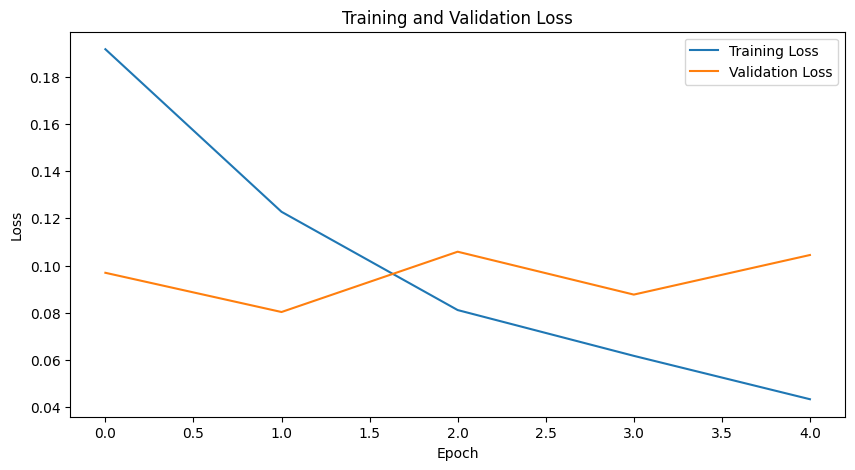

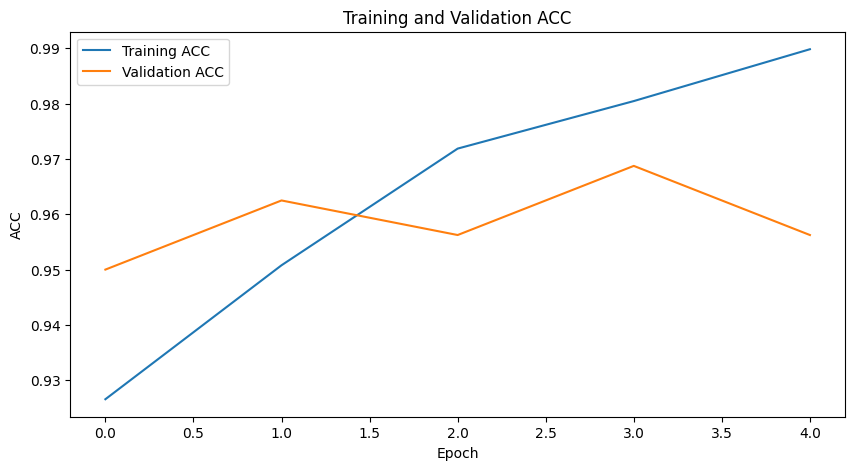

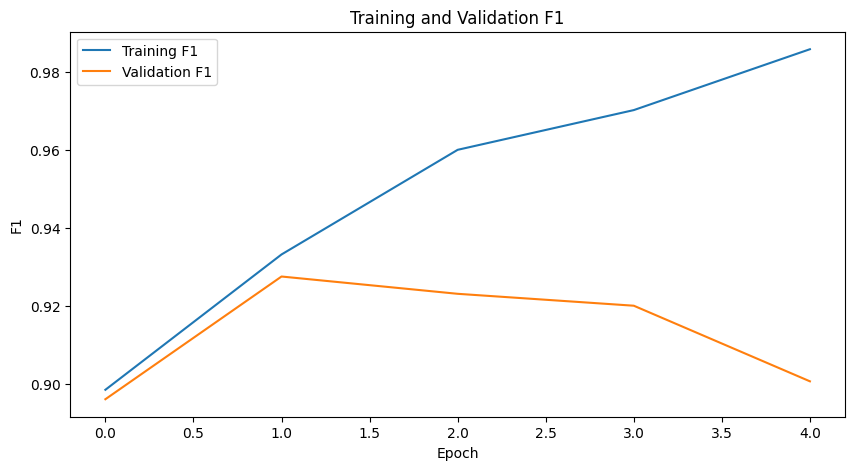

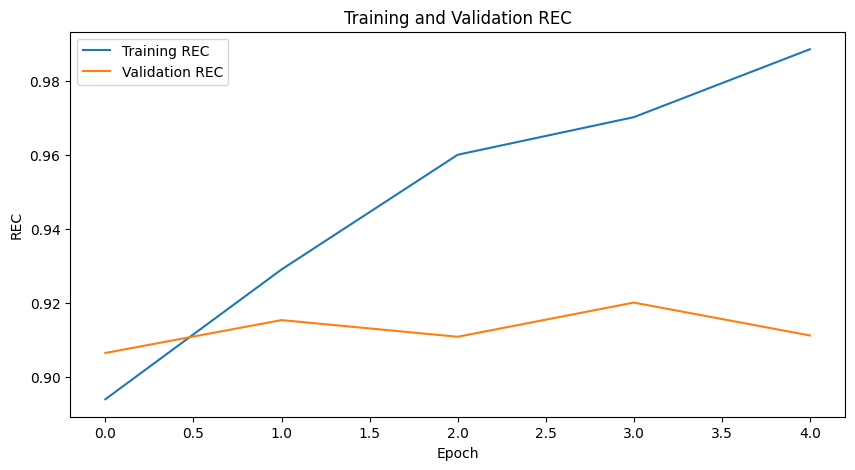

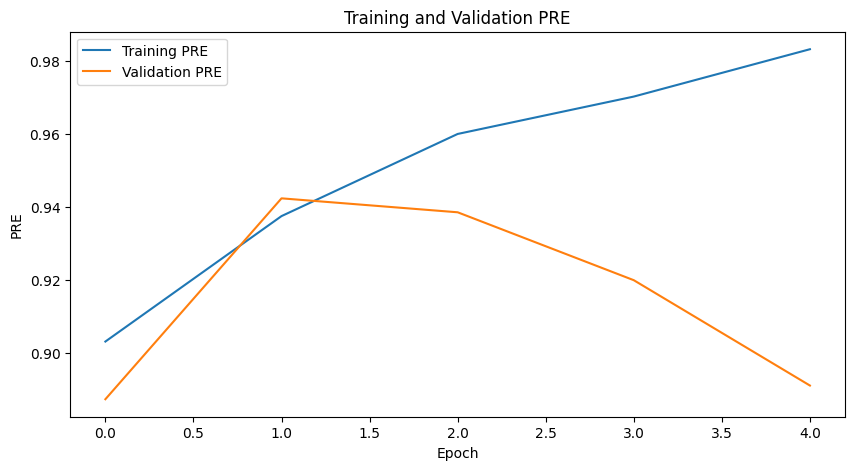

In [53]:
# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting Metrics
metric_names = list(train_metrics_list[0].keys())  # Assuming metrics have same keys for train and validation
for metric_name in metric_names:
    train_metric_values = [metrics[metric_name] for metrics in train_metrics_list]
    valid_metric_values = [metrics[metric_name] for metrics in valid_metrics_list]

    plt.figure(figsize=(10, 5))
    plt.plot(train_metric_values, label='Training ' + metric_name)
    plt.plot(valid_metric_values, label='Validation ' + metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title('Training and Validation ' + metric_name)
    plt.legend()
    plt.show()

## EVALUASI

In [54]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

  0%|          | 0/6 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 6/6 [01:10<00:00, 11.72s/it]


     index     label
0        0  negative
1        1  negative
2        2  negative
3        3  positive
4        4   neutral
..     ...       ...
156    156   neutral
157    157   neutral
158    158   neutral
159    159  negative
160    160  negative

[161 rows x 2 columns]


  0%|          | 0/6 [00:00<?, ?it/s]d:\Software\Anaconda\envs\Cudatest\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 6/6 [01:10<00:00, 11.76s/it]

     index     label
0        0  negative
1        1  negative
2        2  negative
3        3  positive
4        4   neutral
..     ...       ...
156    156   neutral
157    157   neutral
158    158   neutral
159    159  negative
160    160  negative

[161 rows x 2 columns]


## TEST USING NEW TEXT

In [1]:
text = 'Biznet bagus banget koneksi wifinya kenceng pula'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

NameError: name 'tokenizer' is not defined

# OUTPUT GUI

In [58]:
import tkinter as tk
from tkinter import messagebox
import torch
import torch.nn.functional as F

# Asumsi bahwa tokenizer, model, dan i2w sudah diinisialisasi
# tokenizer = ...
# model = ...
# i2w = ...  # Dictionary mapping indices to labels, e.g., {0: "Negative", 1: "Neutral", 2: "Positive"}

def classify_text():
    text = entry.get()
    subwords = tokenizer.encode(text)
    subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)
    
    with torch.no_grad():
        logits = model(subwords)[0]
        label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
        probabilities = F.softmax(logits, dim=-1).squeeze()
        
    result = f'Text: {text} | Label: {i2w[label]} ({probabilities[label] * 100:.3f}%)'
    messagebox.showinfo("Classification Result", result)

# Setup the tkinter GUI
root = tk.Tk()
root.title("Text Classification")

tk.Label(root, text="Enter text:").pack(pady=5)
entry = tk.Entry(root, width=50)
entry.pack(pady=5)

classify_button = tk.Button(root, text="Classify", command=classify_text)
classify_button.pack(pady=5)

root.mainloop()

In [ ]:
import gradio as gr
import torch
import torch.nn.functional as F

i2w = {0: 'positive', 1: 'neutral', 2: 'negative'}

def analyze_text(text):
    subwords = tokenizer.encode(text)
    subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

    logits = model(subwords)[0]
    label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

    result = f'Text: {text} | Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)'
    return result

iface = gr.Interface(fn=analyze_text, inputs="text", outputs="text", title="Analisis Teks", description="Masukkan teks untuk dianalisis")

iface.launch()

## Confusion Matrix

Classification Report on Validation Data:
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85        76
     neutral       0.82      0.89      0.86        74
    positive       0.00      0.00      0.00        10

    accuracy                           0.82       160
   macro avg       0.55      0.59      0.57       160
weighted avg       0.78      0.82      0.80       160

Classification Report on Test Data:
              precision    recall  f1-score   support

    negative       0.68      0.82      0.75        61
     neutral       0.83      0.76      0.79        86
    positive       0.40      0.29      0.33        14

    accuracy                           0.74       161
   macro avg       0.64      0.62      0.62       161
weighted avg       0.74      0.74      0.74       161



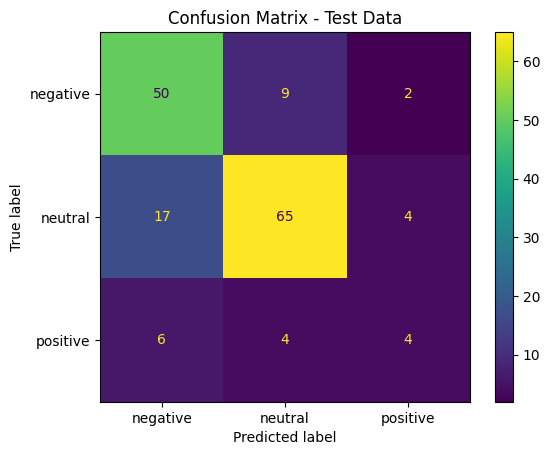

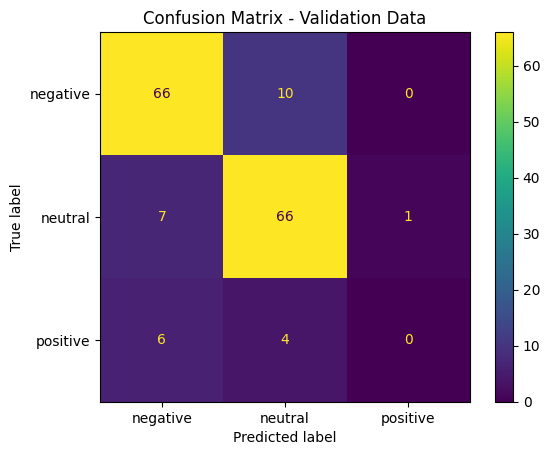

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pra-pemrosesan data (sama seperti yang dilakukan sebelumnya)
# train_data, valid_data, and test_data are assumed to be preprocessed dataframes

# Konversi teks ke vektor fitur menggunakan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train = train_data['sentiment']

# Inisialisasi dan latih model SVM
svm_model = svm.SVC(kernel='linear')  # Anda dapat memilih kernel yang sesuai
svm_model.fit(X_train, y_train)

# Evaluasi model pada data validasi
X_valid = tfidf_vectorizer.transform(valid_data['text'])
y_valid = valid_data['sentiment']
y_pred_valid = svm_model.predict(X_valid)

print("Classification Report on Validation Data:")
print(classification_report(y_valid, y_pred_valid))

# Evaluasi model pada data pengujian
X_test = tfidf_vectorizer.transform(test_data['text'])
y_test = test_data['sentiment']
y_pred_test = svm_model.predict(X_test)

print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix untuk data pengujian
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=svm_model.classes_)
disp_test.plot()
plt.title("Confusion Matrix - Test Data")
plt.show()

# Confusion Matrix untuk data validasi
cm_valid = confusion_matrix(y_valid, y_pred_valid)
disp_valid = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=svm_model.classes_)
disp_valid.plot()
plt.title("Confusion Matrix - Validation Data")
plt.show()